## 3.1 Extracción y creación del conjunto de datos

Uno de los principales retos para el desarrollo de este estudio fue la disponibilidad de un conjunto de datos adecuado que permitiera analizar discursos orales reales desde un enfoque multimodal.
Para solventar esta limitación, se optó por utilizar como fuente los vídeos de conferencias “TED Talks”, ampliamente reconocidos por su diversidad temática, su formato estandarizado y su valor comunicativo.
### 3.1.1 Selección del dataset
Como base del trabajo se empleó el conjunto de datos disponible en la plataforma Kaggle bajo el título “TED Talks”, que recoge un total de 5.440 vídeos, acompañados de metadatos relevantes como título, autor, fecha de publicación, número de visualizaciones, número de "likes" y enlace al vídeo original. Esta base de datos constituye una fuente rica y variada para el análisis de la comunicación oral en contextos reales y públicos.

El conjunto de datos está disponible en:

https://www.kaggle.com/datasets/ashishjangra27/ted-talks

Este dataset se distribuye bajo la licencia Creative Commons BY-NC-SA 4.0 (Atribución – No Comercial – Compartir Igual), lo que permite su uso para fines académicos y de investigación no comercial, siempre que se atribuya adecuadamente y se mantenga la misma licencia en trabajos derivados.


In [1]:
import pandas as pd
import seaborn as sns
import os
from google.colab import drive
import matplotlib.pyplot as plt

# Montamos Google Drive
drive.mount('/content/drive')

#carpeta de trabajo (definir aqui la carpeta donde está el archivo)
folder_path = "/content/drive/MyDrive/Analisis_Multimodal_Comunicacion_TFM/data/folder_path"
os.makedirs(folder_path, exist_ok=True)

Mounted at /content/drive


In [2]:
# Leer CSV
df = pd.read_csv(os.path.join(folder_path, "ted_talks_dataset.csv"))
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5440 non-null   object
 1   author  5439 non-null   object
 2   date    5440 non-null   object
 3   views   5440 non-null   int64 
 4   likes   5440 non-null   int64 
 5   link    5440 non-null   object
dtypes: int64(2), object(4)
memory usage: 255.1+ KB


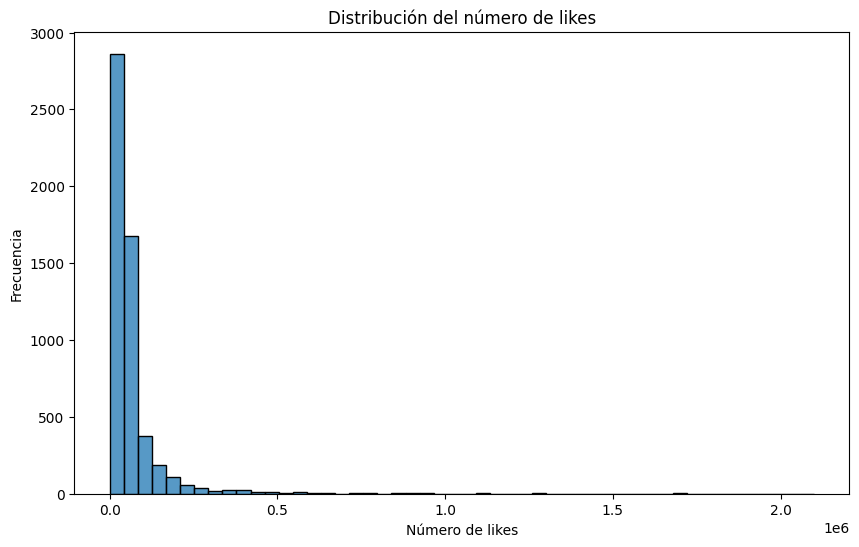

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(x=df['likes'],bins=50)
plt.xlabel('Número de likes')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de likes')
plt.show()

## 3.1.2 Definición de clases y criterio de selección

Para facilitar el análisis comparativo y reducir la carga computacional del procesamiento multimodal, se seleccionaron únicamente los casos extremos del conjunto de datos. Concretamente:

El 25% de los vídeos con mayor número de likes (n=1370), fueron etiquetados como buenos comunicadores (clase 1).

El 25% con menor número de likes (n=1400), fueron etiquetados como malos comunicadores (clase 0).

Esta decisión se basa en los siguientes criterios:

•	Mayor separabilidad de clases: se eligen casos claros de alta y baja calidad comunicativa, lo que facilita el entrenamiento de modelos más robustos.

•	Menor ambigüedad: se evita el ruido inherente a los casos intermedios, donde la valoración de la calidad podría ser más subjetiva o contradictoria.

•	Eficiencia computacional: al trabajar con el 50% del dataset original, se reduce el tiempo de procesamiento y análisis sin perder representatividad.

•	Tamaño de muestra suficiente y equilibrado: se asegura una base sólida para realizar análisis estadísticos y entrenar modelos de clasificación.

## 3.1.3 Uso de la probabilidad de clase como medida continua

Además de la clasificación binaria (0 = baja calidad, 1 = alta calidad), se pretende utilizar la probabilidad de pertenencia a la clase 1, generada por los modelos de aprendizaje automático, como una medida continua de calidad comunicativa.

 Esta estrategia presenta múltiples ventajas:

•	Permite ordenar los discursos de forma más matizada, según su calidad percibida.

•	Captura la incertidumbre del modelo, evitando decisiones tajantes que podrían simplificar en exceso la realidad.

•	Se puede calibrar para representar de forma más precisa la distribución real de niveles de calidad.

•	Permite evaluar discursos intermedios, no utilizados en el entrenamiento, extendiendo la aplicabilidad del modelo a casos fuera del conjunto etiquetado.


In [ ]:


# Número de grupos
n_grupos = 100

# Crear columna 'categoria' basada en percentiles
likes_25 = df['likes'].quantile(0.25)  # 25% inferior
likes_75 = df['likes'].quantile(0.75)  # 25% superior

# Asignamos categorías
# 1 → videos con más likes (top 25%)
# 0 → videos con menos likes (bottom 25%)
# "medios" → el resto
df['categoria'] = df['likes'].apply(
    lambda x: 1 if x >= likes_75 else (0 if x <= likes_25 else "medios")
)

# Filtrar datasets
videos_analisis = df[df["categoria"].isin([0, 1])].copy()
videos_medios = df[df["categoria"] == "medios"].copy()

# Ordenamos videos_analisis por likes de mayor a menor
videos_analisis = videos_analisis.sort_values("likes", ascending=False).reset_index(drop=True)

# Asignamos grupos de forma rotativa
videos_analisis["grupo"] = videos_analisis.index % n_grupos + 1  # grupos de 1 a 100

# Guardar datasets filtrados
videos_analisis.to_csv(os.path.join(folder_path, "videos_analisis.csv"), index=False)
videos_medios.to_csv(os.path.join(folder_path, "videos_medios.csv"), index=False)

# Comprobar resultados
print(df['categoria'].value_counts())
print(videos_analisis.head(100))
print(videos_medios.head())


categoria
medios    2670
0         1400
1         1370
Name: count, dtype: int64
                                              title            author  \
0                       Do schools kill creativity?  Sir Ken Robinson   
1          Your body language may shape who you are         Amy Cuddy   
2        Inside the mind of a master procrastinator         Tim Urban   
3                  How great leaders inspire action       Simon Sinek   
4                        The power of vulnerability       Brené Brown   
..                                              ...               ...   
95                    The loathsome lethal mosquito      Rose Eveleth   
96  Why we all need to practice emotional first aid         Guy Winch   
97    How playing an instrument benefits your brain     Anita Collins   
98                          How Thor got his hammer   Scott A. Mellor   
99                  My journey from Marine to actor       Adam Driver   

              date     views    likes  \
0

Creamos así el archivo videos_analisis_csv que con tiene 2770 datos de videos con el campo "categoria" 0 y 1 que posteriormente se utilizarán para el entrenamiento del modelo y renombrando el campo como "tipo_comunicador".

Además debido al elevado coste computacional que supone el análisis multimodal de los 2.770 vídeos seleccionados, se optó por agruparlos en 100 lotes balanceados

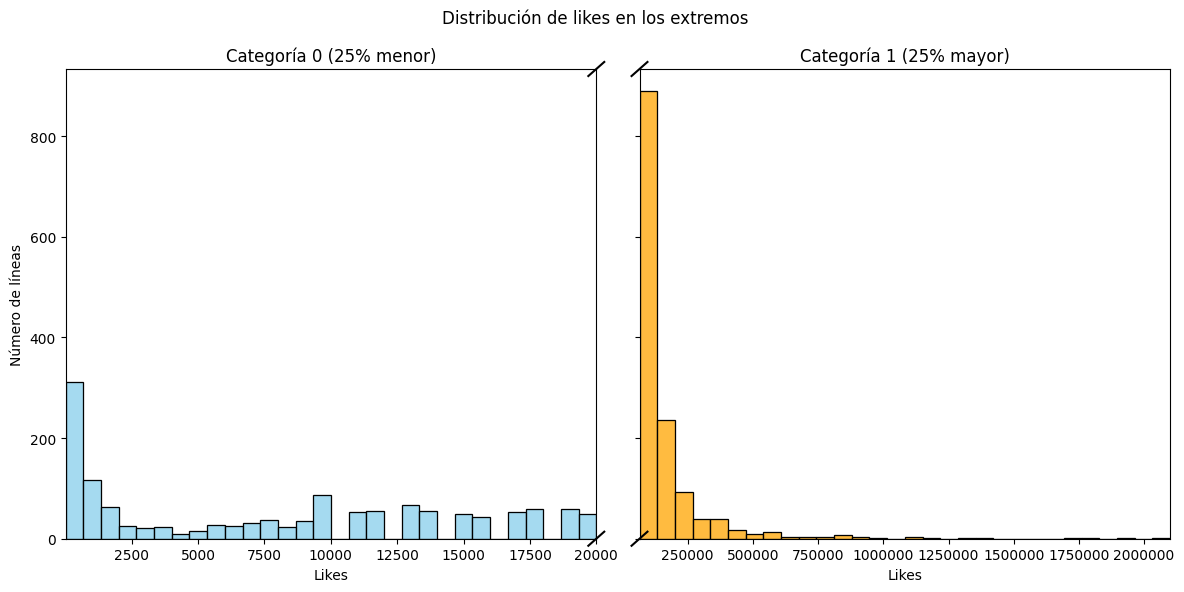

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# Separar los datos
df_0 = videos_analisis[videos_analisis['categoria'] == 0]
df_1 = videos_analisis[videos_analisis['categoria'] == 1]

# Crear figura con 2 subgráficos (eje X partido)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

# Histograma categoría 0
sns.histplot(data=df_0, x='likes', bins=30, ax=ax1, color='skyblue')
ax1.set_title('Categoría 0 (25% menor)')
ax1.set_xlabel('Likes')
ax1.set_ylabel('Número de líneas')
ax1.set_xlim(df_0['likes'].min(), df_0['likes'].max())

# Histograma categoría 1
sns.histplot(data=df_1, x='likes', bins=30, ax=ax2, color='orange')
ax2.set_title('Categoría 1 (25% mayor)')
ax2.set_xlabel('Likes')
ax2.set_ylabel('')
ax2.set_xlim(df_1['likes'].min(), df_1['likes'].max())

# 💡 Forzar formato numérico completo en ambos ejes X
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)

ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

# Líneas diagonales para indicar "salto"
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

# Título general
plt.suptitle('Distribución de likes en los extremos')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

